In [1]:
from collections import defaultdict
import csv
from sklearn import linear_model
from sklearn.decomposition import PCA
import scipy
import scipy.optimize
import numpy
import random

In [2]:
def readCSV(path):
  f = open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')
    
def calc_model_stats(pred,label):
    
    TP,FP,TN,FN = calc_metrics(pred,label)

    # print("Stats")
    # print(TP,FP,TN,FN)

    # print("Predict N: {} ({}%)".format(TN+FN,(TN+FN)/(TP+TN+FP+FN)))
    # print("Predict P: {} ({}%)".format(TP+FP,(TP+FP)/(TP+TN+FP+FN)))

    accuracy, TPR, TNR, BER = calc_error_rates(TP, FP, TN, FN)

    print("Accuracy: {}".format(accuracy))
    # print("TPR: {}".format(TPR))
    # print("TNR: {}".format(TNR))
    # print("BER: {}".format(BER))
    
    return
 
def calc_metrics(predictions, labels):
    # Calculate True positives, false positives, etc.

    TP_ = numpy.logical_and(predictions, labels)
    FP_ = numpy.logical_and(predictions, numpy.logical_not(labels))
    TN_ = numpy.logical_and(numpy.logical_not(predictions), numpy.logical_not(labels))
    FN_ = numpy.logical_and(numpy.logical_not(predictions), labels)

    TP=sum(TP_)
    FP=sum(FP_)
    TN=sum(TN_)
    FN=sum(FN_)
    
    return TP,FP,TN,FN

def calc_error_rates(TP, FP, TN, FN):
    # Calculate accuracy, TPR, TNR and BER
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    BER = 1.0 - (TPR+TNR)/2
    
    return accuracy, TPR, TNR, BER


### Split Training Dataset into Train and Validation Datasets

In [18]:
dataset = []

for user,book,rating in readCSV("assignment1/train_Interactions.csv"):
  dataset.append([user,book,rating])

random.shuffle(dataset)

X = [values[0:2] for values in dataset]
y = [int(values[-1]) for values in dataset]

N = len(dataset)
Ntrain = 190001

Xtrain = X[:Ntrain]
Xvalid = X[Ntrain:]

ytrain = y[:Ntrain]
yvalid = y[Ntrain:]

print(N, len(ytrain),len(yvalid))

200000 190001 9999


### Adopt code from Workbook 4

In [19]:
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)

for user,book,rating in dataset:
    ratingsPerUser[user].append(rating)
    ratingsPerItem[book].append(rating)

N = len(Xtrain)
nUsers = len(ratingsPerUser)
nItems = len(ratingsPerItem)
users = list(ratingsPerUser.keys())
items = list(ratingsPerItem.keys())

print (nUsers, nItems)
print (users[:3])
print (items[:3])

11357 7170
['u08619852', 'u69186302', 'u59611275']
['b45122162', 'b23498394', 'b39167058']


In [20]:
ratingMean = sum([y for y in ytrain])/len(ytrain)

print("Mean of ratings in training set: {}".format(ratingMean))

Mean of ratings in training set: 3.897432118778322


In [21]:
alpha = ratingMean

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))
    
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xtrain]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for i in itemBiases:
        cost += lamb*itemBiases[i]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    for value in zip(Xtrain,ytrain):
        x,rating = value
        user = x[0]
        book = x[1]
        pred = prediction(user,book)
        diff = pred - rating
        dalpha += 2/N*diff
        dUserBiases[user] += 2/N*diff
        dItemBiases[book] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    return numpy.array(dtheta)

In [ ]:
lamb_values = [5e-6,1e-5,1.3e-5,1.5e-5,1.7e-5,1.8e-5,2e-5,5e-5]
MSE_valid =[]
best_theta = []
best_MSE = 0

for lamb in lamb_values:
    print("Lambda = {}".format(lamb))
  
    theta_init = [alpha] + [0.0]*(nUsers+nItems)
    unpack(theta_init)
    
    def cost(theta, labels, lamb):
        unpack(theta)
        predictions = [prediction(user, book) for user,book in Xtrain]
        cost = MSE(predictions, labels)
        print("MSE = " + str(cost))
        for u in userBiases:
            cost += lamb*userBiases[u]**2
        for i in itemBiases:
            cost += lamb*itemBiases[i]**2
        return cost

    def derivative(theta, labels, lamb):
        unpack(theta)
        N = len(dataset)
        dalpha = 0
        dUserBiases = defaultdict(float)
        dItemBiases = defaultdict(float)
        for value in zip(Xtrain,ytrain):
            x,rating = value
            user = x[0]
            book = x[1]
            pred = prediction(user,book)
            diff = pred - rating
            dalpha += 2/N*diff
            dUserBiases[user] += 2/N*diff
            dItemBiases[book] += 2/N*diff
        for u in userBiases:
            dUserBiases[u] += 2*lamb*userBiases[u]
        for i in itemBiases:
            dItemBiases[i] += 2*lamb*itemBiases[i]
        dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
        return numpy.array(dtheta)
    
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))

    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xvalid]
    cost = MSE(predictions, yvalid)
    
    if best_MSE is 0:
        best_MSE = cost
        best_theta = theta
        print("Save best theta...")
    else:
        if cost < best_MSE:
            best_MSE = cost
            best_theta = theta
            print("Save best theta...")
    
    MSE_valid.append(cost)
    print(cost)

Lambda = 5e-06
MSE = 1.4729036011963463
MSE = 1.45549995103297
MSE = 1.3918703762792872
MSE = 7.815150612904498
MSE = 1.3665493837875067
MSE = 1.2013867055418774
MSE = 1.1993770551775633
MSE = 1.1914990400430507
MSE = 1.1625563606695182
MSE = 1.0481821127230535
MSE = 0.9974694671216988
MSE = 0.9624786726764067
MSE = 0.9473460920576432
MSE = 0.9330358434909432
MSE = 0.919058079461447
MSE = 0.9206393508695698
MSE = 0.9149452202991889
MSE = 0.9117981800847383
MSE = 0.911109804931308
MSE = 0.9099839168670275
MSE = 0.9093450638147883
MSE = 0.9083705547508636
MSE = 0.9107784455747173
MSE = 0.9083483290907004
MSE = 0.9080277691643748
MSE = 0.9072007882197884
MSE = 0.9071524343434314
MSE = 0.9067528743630965
MSE = 0.906281026577777
MSE = 0.9061089495624772
MSE = 0.9094871767538625
MSE = 0.9062694315815029
MSE = 0.9066846884459324
MSE = 0.9061827962356823
MSE = 0.9060174202688851
MSE = 0.9055411923220819
MSE = 0.9054116465006874
MSE = 0.905459028438891
MSE = 0.9054177269652793
MSE = 0.905361920

MSE = 0.9151814917149154
MSE = 0.9152202996539033
MSE = 0.9152943491971088
MSE = 0.9152459114424125
MSE = 0.9152055792482447
MSE = 0.9151529241843603
MSE = 0.9150224407581429
MSE = 0.9149719901670378
MSE = 0.9149979674895398
MSE = 0.9150453077983646
MSE = 0.9150092401011835
MSE = 0.9150809346465304
MSE = 0.915021537799298
MSE = 0.9150118708636921
MSE = 0.9150182442175305
MSE = 0.9150132037415936
MSE = 0.9150165285982256
MSE = 0.9150138909837826
MSE = 0.9150133474895833
MSE = 0.9150132037415936
MSE = 0.9150922044194659
MSE = 0.9150270691095148
MSE = 0.915016265810648
MSE = 0.9150233879428483
MSE = 0.9151068233162635
MSE = 0.9150367730537319
MSE = 0.9150260496738989
MSE = 0.9150239386983444
MSE = 0.9150235028323818
MSE = 0.9150234119497969
MSE = 0.9150233929609679
MSE = 0.9150233889919108
MSE = 0.9150233881621612
MSE = 0.9150233879887512
MSE = 0.9150233879525587
MSE = 0.9150233879448392
MSE = 0.9150233879499542
MSE = 0.9150233879457036
MSE = 0.9150233879449997
MSE = 0.9150233879448392
Sa

MSE = 1.4679389263274478
MSE = 1.4600177385229884
MSE = 1.4408016483043664
MSE = 1.39791714901481
MSE = 1.3227328362049946
MSE = 1.2402148976196472
MSE = 1.2001662275725729
MSE = 1.1949674184449914
MSE = 1.195266359463202
MSE = 1.1951092102697434
MSE = 1.1924309375898683
MSE = 1.1845983078684874
MSE = 1.1638743988093294
MSE = 1.1268553460298574
MSE = 1.0862464366852256
MSE = 1.0623724998762534
MSE = 38.35857038150427
MSE = 1.0589577448016956
MSE = 1.0573837364848895
MSE = 1.055601729526572
MSE = 1.0450375204002105
MSE = 1.023166838455285
MSE = 0.9970723539805406
MSE = 0.9902806252241996
MSE = 0.9832107437865016
MSE = 0.9721715999998275
MSE = 0.9629534459103308
MSE = 0.9549763087310611
MSE = 0.9521835059714427
MSE = 0.9493883974801072
MSE = 0.9488668794208023
MSE = 0.947576416385572
MSE = 0.9461274754458642
MSE = 0.943803403375945
MSE = 0.9733727795079011
MSE = 0.9435388571814507
MSE = 0.9411256149464852
MSE = 0.937326526370369
MSE = 0.934803758718531
MSE = 1.5819790251456625
MSE = 0.93

In [9]:
for lamb, MSE in zip(lamb_values ,MSE_valid):
    print ("Lamb-{} gives MSE of {}".format(lamb, MSE))

Lamb-5e-06 gives MSE of 1.0565573120328633
Lamb-1e-05 gives MSE of 1.0488266922268992
Lamb-1.3e-05 gives MSE of 1.0474291884121865
Lamb-1.5e-05 gives MSE of 1.0466573134011867
Lamb-1.7e-05 gives MSE of 1.0465015842591365
Lamb-1.8e-05 gives MSE of 1.0464545634319113
Lamb-2e-05 gives MSE of 1.0469504320573924
Lamb-5e-05 gives MSE of 1.07138245322055


## (11) Kaggle Submission - Lambda=1.2e-5,  MSE=1.143, User_Name='Luke Liem'

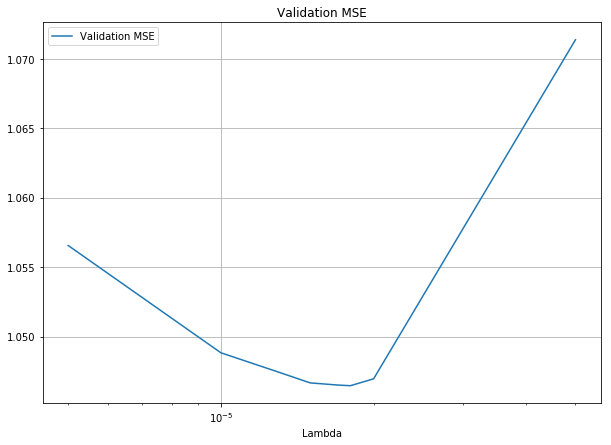

In [11]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.xlabel('Lambda')
plt.title('Validation MSE')
plt.xscale('log')
plt.grid(True)

plt.plot(lamb_values, MSE_valid, label='Validation MSE')

plt.legend()
plt.show()

In [24]:
best_theta

array([ 3.81233938,  0.3113362 ,  0.46095858, ..., -0.3010043 ,
       -0.01805242, -0.26187858])

In [12]:
### Rating baseline: compute averages for each user, or return 
### the global average if we've never seen the user before

predictions = open("assignment1/predictions_Rating.txt", 'w')
unpack(best_theta)

for l in open("assignment1/pairs_Rating.txt"):
  # write header  
  if l.startswith("userID"):
    predictions.write(l)
    continue
    
  # write user-item-rating
  u,b = l.strip().split('-')
  predictions.write(u + '-' + b + ',' + str(prediction(u,b)) + '\n')

predictions.close()

In [13]:
alpha = ratingMean

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

userGamma = {}
itemGamma = {}

K = 1

# Initialize user and item Gammas
for u in ratingsPerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in ratingsPerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

In [14]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    itemBiases = dict(zip(items, theta[index:index+nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index+K]
        index += K
        
def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item] + inner(userGamma[user], itemGamma[item])

   
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xtrain]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in items:
        cost += lamb*itemBiases[i]**2
        for k in range(K):
            cost += lamb*itemGamma[i][k]**2
    return cost


def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in ratingsPerUser:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in ratingsPerItem:
        dItemGamma[i] = [0.0 for k in range(K)]
    for value in zip(Xtrain,ytrain):
        x,rating = value
        u = x[0]
        i = x[1]
        pred = prediction(u, i)
        diff = pred - rating
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
            dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return numpy.array(dtheta)

In [15]:
lamb_values = [1e-4, 8e-5, 6e-5, 5e-5, 4e-5, 3e-5, 2e-5, 1e-5]
MSE_valid =[]
thetas=[]
best_theta = []
best_MSE = 0

for lamb in lamb_values:
    print("Lambda = {}".format(lamb))
  
    theta_init = [alpha] + [0.0]*(nUsers+nItems) +  \
            [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))]
    unpack(theta_init)
    
    def cost(theta, labels, lamb):
        unpack(theta)
        predictions = [prediction(user, book) for user,book in Xtrain]
        cost = MSE(predictions, labels)
        print("MSE = " + str(cost))
        for u in users:
            cost += lamb*userBiases[u]**2
            for k in range(K):
                cost += lamb*userGamma[u][k]**2
        for i in items:
            cost += lamb*itemBiases[i]**2
            for k in range(K):
                cost += lamb*itemGamma[i][k]**2
        return cost

    def derivative(theta, labels, lamb):
        unpack(theta)
        N = len(dataset)
        dalpha = 0
        dUserBiases = defaultdict(float)
        dItemBiases = defaultdict(float)
        dUserGamma = {}
        dItemGamma = {}
        for u in ratingsPerUser:
            dUserGamma[u] = [0.0 for k in range(K)]
        for i in ratingsPerItem:
            dItemGamma[i] = [0.0 for k in range(K)]
        for value in zip(Xtrain,ytrain):
            x,rating = value
            u = x[0]
            i = x[1]
            pred = prediction(u, i)
            diff = pred - rating
            dalpha += 2/N*diff
            dUserBiases[u] += 2/N*diff
            dItemBiases[i] += 2/N*diff
            for k in range(K):
                dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
                dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
        for u in userBiases:
            dUserBiases[u] += 2*lamb*userBiases[u]
            for k in range(K):
                dUserGamma[u][k] += 2*lamb*userGamma[u][k]
        for i in itemBiases:
            dItemBiases[i] += 2*lamb*itemBiases[i]
            for k in range(K):
                dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
        dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
        for u in users:
            dtheta += dUserGamma[u]
        for i in items:
            dtheta += dItemGamma[i]
        return numpy.array(dtheta)
    
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))
    thetas.append(theta)  # save thetas

    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xvalid]
    cost = MSE(predictions, yvalid)
    
    if best_MSE is 0:
        best_MSE = cost
        best_theta = theta
        print("Save best theta...")
    else:
        if cost < best_MSE:
            best_MSE = cost
            best_theta = theta
            print("Save best theta...")
    
    MSE_valid.append(cost)
    print(cost)

Lambda = 0.0001
MSE = 1.4766989665078663
MSE = 1.4592531237788307
MSE = 1.3955163010433882
MSE = 6.9280036964829765
MSE = 1.3789373837633976
MSE = 1.2241153291336495
MSE = 1.2224442163132039
MSE = 1.2158982121826267
MSE = 1.1919293475430097
MSE = 1.1010788777220404
MSE = 1.080466649094125
MSE = 1.066536647231598
MSE = 1.067191499712173
MSE = 1.0680549454268051
MSE = 1.0674202195325766
MSE = 1.0665042368073523
MSE = 1.0662219246830118
MSE = 1.0665754804863072
MSE = 1.0662423814503126
MSE = 1.066223743693595
MSE = 1.0662220916181206
MSE = 1.066221940046847
MSE = 1.0662219260974042
MSE = 1.0662219248131315
MSE = 1.0662219246950357
MSE = 1.066221924684062
MSE = 1.0662219246831035
MSE = 1.0662219246831208
MSE = 1.066221924683103
MSE = 1.066221924683103
MSE = 1.0662219246831128
MSE = 1.066221924683103
Save best theta...
1.1195637405724344
Lambda = 8e-05
MSE = 1.4799578535293365
MSE = 2.341060858811238
MSE = 1.4765796345029367
MSE = 1.4763716957999933
MSE = 1.4757903972722801
MSE = 1.47431326

MSE = 0.9893298489523962
MSE = 0.9890483578726926
MSE = 0.9888013748376823
MSE = 0.9886805664640543
MSE = 0.9887577746967865
MSE = 0.9887234178518244
MSE = 0.9887173400505092
MSE = 0.988775449146637
MSE = 0.9888243194409291
MSE = 0.988786119034068
MSE = 0.9888537829903127
MSE = 0.988797705786093
MSE = 0.9887884893441429
MSE = 0.9887866208741741
MSE = 0.9887878538515085
MSE = 0.9887868809465961
MSE = 0.9887875230061113
MSE = 0.9887870161139782
MSE = 0.9887869094577726
MSE = 0.9887868809465961
Save best theta...
1.071115508630035
Lambda = 4e-05
MSE = 1.4815821604162833
MSE = 2.3251225295483073
MSE = 1.4765995352572716
MSE = 1.476375555476137
MSE = 1.4759141479625486
MSE = 1.4745858132619707
MSE = 1.4712654058463197
MSE = 1.4626756944761425
MSE = 1.4417802561950266
MSE = 1.395705726504987
MSE = 1.3169872546114392
MSE = 1.2336417565004234
MSE = 1.1971455571242333
MSE = 1.1950710664870487
MSE = 1.1959335697670115
MSE = 1.196191421132795
MSE = 1.194615375075897
MSE = 1.187316184141594
MSE = 

MSE = 0.997054902875961
MSE = 0.9939772542331194
MSE = 0.9921334884472892
MSE = 0.9859034097329414
MSE = 0.9782912526442846
MSE = 0.9664518191259079
MSE = 91.74040301879593
MSE = 0.9646352022194975
MSE = 0.9637040246835705
MSE = 0.9642397707783756
MSE = 0.9641742871919249
MSE = 0.9608855874139856
MSE = 0.9580399932291661
MSE = 0.9551299183216728
MSE = 0.9499463350398171
MSE = 0.9452104313361431
MSE = 0.9390268087407729
MSE = 0.9409365707374001
MSE = 0.9420930243174254
MSE = 0.9492916311433669
MSE = 0.9422576770379278
MSE = 0.9422153884529941
MSE = 0.943829808288762
MSE = 0.9402380725382117
MSE = 0.9368433933184903
MSE = 0.9351715448726786
MSE = 0.945469297315658
MSE = 0.935465512679829
MSE = 0.9348234153553014
MSE = 0.9348900482915545
MSE = 0.934630758069898
MSE = 0.934254186841026
MSE = 0.9344693717155708
MSE = 0.9340555775719608
MSE = 0.9332732830587205
MSE = 0.932144284185806
MSE = 0.9316902152641791
MSE = 0.9321233938514913
MSE = 0.9305751434985555
MSE = 0.9301010163195954
MSE = 0.

MSE = 0.7824097851747924
MSE = 0.7823644884872577
MSE = 0.7828626884661485
MSE = 0.7821410800843203
MSE = 0.7822299866779437
MSE = 0.7824659723809098
MSE = 0.7825516554301539
MSE = 0.7827052290960022
MSE = 0.7828666543728408
MSE = 0.7830469198311837
MSE = 0.7912439013997417
MSE = 0.78302140220201
MSE = 0.7830338056644165
MSE = 0.7828554398888296
MSE = 0.782648135117561
MSE = 0.782465453342987
MSE = 0.7822406447264393
MSE = 0.7821888302556201
MSE = 0.7824398401122676
MSE = 0.7821676539181365
MSE = 0.7822695291690348
MSE = 0.7822765654408517
MSE = 0.782230629466258
MSE = 0.7821008523942753
MSE = 0.7817044392148064
MSE = 0.7818747366919953
MSE = 0.7817500669042853
MSE = 0.7816824212514187
MSE = 0.7816540382960201
MSE = 0.7816148916112922
MSE = 0.7814689293360321
MSE = 0.7933764279105288
MSE = 0.7814577511207711
MSE = 0.7813653212125389
MSE = 0.7813215890929162
MSE = 0.7813331276224937
MSE = 0.7812907399930769
MSE = 0.7811287785735163
MSE = 0.7810288195650583
MSE = 0.7810501199234438
MSE =

MSE = 0.7595880247641791
MSE = 0.7578763169260636
MSE = 0.755308547153392
MSE = 0.7560723306644626
MSE = 0.7547134581636643
MSE = 0.7532601782580878
MSE = 0.7508471019552001
MSE = 0.7503660907140955
MSE = 0.7504123418785397
MSE = 0.7519120365036425
MSE = 0.7501350817067559
MSE = 0.7505659314282304
MSE = 0.7490711657952358
MSE = 0.7502193447063417
MSE = 0.7504646527841926
MSE = 0.7492519032064167
MSE = 0.7507655072672951
MSE = 0.7470624737798144
MSE = 0.7488777140289617
MSE = 0.7486861097401223
MSE = 0.7480532788119771
MSE = 0.7479847662530419
MSE = 0.7479140332597207
MSE = 0.7478782948105345
MSE = 0.7484734860431653
MSE = 0.7484972213678687
MSE = 0.7481728946946666
MSE = 0.7481678836833571
MSE = 0.7470746111507487
MSE = 0.7466929606008107
MSE = 0.7449538922031376
MSE = 0.740499411366268
MSE = 0.7437978767085498
MSE = 0.7438685586987626
MSE = 0.7439853735042166
MSE = 0.7440627017409704
MSE = 0.7440662544313177
MSE = 0.7439285472795972
MSE = 0.7433429048993084
MSE = 0.7425427044083974
MS

MSE = 0.7180776736639707
MSE = 0.7180502557799187
MSE = 0.7184504403922077
MSE = 0.7180722804944254
MSE = 0.7180295295271224
MSE = 0.857451966229276
MSE = 0.7179947259776905
MSE = 0.7179585247445018
MSE = 0.7185429812764594
MSE = 0.718149725239804
MSE = 0.7187159377981968
MSE = 0.7180276664023297
MSE = 0.7181411013576962
MSE = 0.7181854915724788
MSE = 0.7182196761196596
MSE = 0.7183056758759107
MSE = 0.7184116369615371
MSE = 0.7184303721246468
MSE = 0.7202750446702622
MSE = 0.7185065742765843
MSE = 0.7183691347552243
MSE = 0.7184929544345597
MSE = 0.7183759374337819
MSE = 0.7183254676285316
MSE = 0.7182511802285885
MSE = 0.7244009279370879
MSE = 0.7182734173918539
MSE = 0.7182035474445972
MSE = 0.718313052840418
MSE = 0.718190863748158
MSE = 0.718134709554802
MSE = 0.7180460286587415
MSE = 0.717750982840886
MSE = 0.7210312941286223
MSE = 0.717722684870176
MSE = 0.7176785096115454
MSE = 0.7176761686307277
MSE = 0.7178177822095686
MSE = 0.7177169625510079
MSE = 0.7177567705311487
MSE = 0

MSE = 0.7143997515629876
MSE = 0.7143695957370829
MSE = 0.7143382619164726
MSE = 0.714346214034956
MSE = 0.714330188904363
MSE = 0.7143146370630714
MSE = 0.7142827010807932
MSE = 0.714234947195649
MSE = 0.7142461905148001
MSE = 0.714223924622949
MSE = 0.7142264031831489
MSE = 0.7142279218349026
MSE = 0.7141947559837918
MSE = 0.7142076598217236
MSE = 0.7141933538100788
MSE = 0.7141959028945822
MSE = 0.7142047393625797
MSE = 0.7143596496917283
MSE = 0.7142040489472051
MSE = 0.7142061611659403
MSE = 0.7141798289564465
MSE = 0.7141423190773005
MSE = 0.7141115730388543
MSE = 0.7140211172994375
MSE = 0.7139993697247389
MSE = 0.7140042151506623
MSE = 0.7139870068738757
MSE = 0.7140087232656595
MSE = 0.7139886362631509
MSE = 0.7139945902321347
MSE = 0.7140048424003506
MSE = 0.7140093740909844
MSE = 0.7140036645766613
MSE = 0.7140000282987895
MSE = 0.7139028260983962
MSE = 0.7139372301148692
MSE = 0.7139549882015354
MSE = 0.7139480057276008
MSE = 0.7139500080033434
MSE = 0.713939325416322
MSE =

MSE = 0.7126341433570186
MSE = 0.7126303303898803
MSE = 0.7126515565073707
MSE = 0.7126262846545771
MSE = 0.7126098944689125
MSE = 0.712439643186854
MSE = 0.7125953265552112
MSE = 0.712589970844327
MSE = 0.7125814746283924
MSE = 0.7125417209818029
MSE = 0.7125943219513214
MSE = 0.7125772796931051
MSE = 0.7125758656175434
MSE = 0.713529563284686
MSE = 0.7125785859368118
MSE = 0.71257640374093
MSE = 0.7125775052147828
MSE = 0.7125801011673527
MSE = 0.7178704510111205
MSE = 0.7125783245699268
MSE = 0.7125767229278613
MSE = 0.7128714720126734
MSE = 0.7125877861515957
MSE = 0.7125744322284467
MSE = 0.712547466467825
MSE = 0.7125035621084138
MSE = 0.7125514800680083
MSE = 0.7125116412550617
MSE = 0.7125285567938486
MSE = 0.7125157568296521
MSE = 0.7125312781517618
MSE = 0.7125199444005418
MSE = 0.715752206668774
MSE = 0.7125212631295493
MSE = 0.7125328309502872
MSE = 0.7128971145660026
MSE = 0.7125316368242912
MSE = 0.7125335803460083
MSE = 0.7123964200638175
MSE = 0.7125189078606041
MSE = 0

MSE = 0.7118640853043363
MSE = 0.7118659625060971
MSE = 0.7118494220580887
MSE = 0.7118617297826884
MSE = 0.7118655652227875
MSE = 0.7118739971122557
MSE = 0.711877394507866
MSE = 0.7118742283750465
MSE = 0.7118789627984343
MSE = 0.7118737490785157
MSE = 0.7118669573354716
MSE = 0.7118669679478432
MSE = 0.7118664689994267
MSE = 0.7118661877005925
MSE = 0.712009821444584
MSE = 0.7118634226646708
MSE = 0.7118600263112047
MSE = 0.7118551163573141
MSE = 0.7125132247475527
MSE = 0.7118458469940225
MSE = 0.7118406256736841
MSE = 0.7118303217987607
MSE = 0.7121439427275478
MSE = 0.7118280248798297
MSE = 0.7118231861123169
MSE = 0.7118159618606156
MSE = 0.7118186323140921
MSE = 0.7118181452842297
MSE = 0.7118199373401087
MSE = 0.7118147298949273
MSE = 0.7118103502140172
MSE = 0.7118034179948813
MSE = 0.7117505377933069
MSE = 0.7117880679790567
MSE = 0.711794866068771
MSE = 0.7117891727760549
MSE = 0.7117882844628806
MSE = 0.7117881118876771
MSE = 0.711788076946597
MSE = 0.7117880698130786
MSE 

In [16]:
for lamb, MSE in zip(lamb_values ,MSE_valid):
    print ("Lamb-{} gives MSE of {}".format(lamb, MSE))

Lamb-0.0001 gives MSE of 1.1195637405724344
Lamb-8e-05 gives MSE of 1.1013907720554
Lamb-6e-05 gives MSE of 1.0807068634356816
Lamb-5e-05 gives MSE of 1.071115508630035
Lamb-4e-05 gives MSE of 1.062854458948445
Lamb-3e-05 gives MSE of 1.0518645992698112
Lamb-2e-05 gives MSE of 1.1310767507029222
Lamb-1e-05 gives MSE of 1.2187399719836565


In [17]:
### Rating baseline: compute averages for each user, or return 
### the global average if we've never seen the user before

predictions = open("assignment1/predictions_Rating.txt", 'w')
unpack(best_theta)

for l in open("assignment1/pairs_Rating.txt"):
  # write header  
  if l.startswith("userID"):
    predictions.write(l)
    continue
    
  # write user-item-rating
  u,b = l.strip().split('-')
  predictions.write(u + '-' + b + ',' + str(prediction(u,b)) + '\n')

predictions.close()